<img src="../images/house.jpeg" style="float: center; margin: 20px; height: 55px">

##  Ames Housing Data and Kaggle Challenge

_Author: Afolabi Cardoso_

---

## Lasso Model

---
#### Contents
[Overview](#Overview) | [Imports](#Imports) | [Feature Selection](#Feature-Selection) | [Model Creation](#Model-Creation) | [Model Fit](#Model-Fit) | [Model Evaluation](#Model-Evaluation) | [Conclusion](#Conclusion) | [Kaggle Submission](#Kaggle-Submission)

---
## Overview

In this model, I will be using a technique called <b>Lasso Regression</b>

$ \|\mathbf{y} - \mathbf{X}\beta\|^2 + \alpha\|\beta\|_1 $

The Lasso regression which stands for Least Absolute Shrinkage and Selection is a technique used to simplify a regression model by adding a penalty to both coefficients and outliers

---
## Imports

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso, LassoCV

#### Import the train dataset as df

In [56]:
df = pd.read_csv('../datasets/train_clean.csv',index_col=[0])

#### Import the test (Kaggle) dataset as df_test

In [57]:
df_test = pd.read_csv('../datasets/test_clean.csv',index_col=[0])

---
## Feature Selection

Before I dummify the categorical variables, I am going to concat the train and test dataset. This is done to ensure that both datasets have equal number of columns after dummification

In [58]:
objects_to_drop = ['House Style','Condition 1',
'Roof Matl','Exterior 2nd']
df.drop(columns=objects_to_drop, inplace=True)
df_test.drop(columns=objects_to_drop, inplace=True)

In [59]:
df_concat = pd.concat((df, df_test))

/Users/captcardoso/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Using get_dummies method I dummify the concated dataset

In [60]:
df_concat_dummies = pd.get_dummies(df_concat, drop_first=True)

Split concatenated datasets into seperate train and test datasets

In [61]:
df_train = df[['Id']].merge(df_concat_dummies, how='left')
df_test = df_test[['Id']].merge(df_concat_dummies, how='left').drop(columns=['SalePrice'])

During the dummification, SalePrice was converted into floats. Using lambda function I'll convert it back to integer

In [62]:
df_train['SalePrice'] = df_train['SalePrice'].map(lambda x: int(x))

In [63]:
df_train.corr()[['SalePrice']].loc['Sale Type_VWD']

SalePrice   NaN
Name: Sale Type_VWD, dtype: float64

#### Drop columns with low correlation first

In [64]:
low_corr = ['Screen Porch','Bedroom AbvGr','3Ssn Porch','Mo Sold','BsmtFin SF 2',
       'Pool Area','Misc Val','Yr Sold','Low Qual Fin SF','Bsmt Half Bath','MS SubClass','Overall Cond','Kitchen AbvGr','Enclosed Porch']

In [65]:
objects_to_drop = ['House Style','Condition 1',
'Roof Matl','Exterior 2nd']

integers_to_drop = ['2nd Flr SF','Gr Liv Area','Garage Yr Blt','Year Remod/Add']

In [66]:
df_train.drop(columns=low_corr+integers_to_drop, inplace=True)
df_test.drop(columns=low_corr+integers_to_drop, inplace=True)

---
## Model Creation

Create model parameters

In [67]:
features = list(df_train.columns) 

In [68]:
X = df_train[features].drop(columns=['SalePrice'])
y = df_train['SalePrice']

#### Train/test/split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

#### Applying Standard Scaler on train dataset

In [70]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

#### Applying Standard Scaler on test dataset

In [71]:
df_test_ss = ss.transform(df_test)

#### Instantiate Lasso Regression Model

In [72]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

## Model Fit

#### Baseline

In [73]:
y.mean()

181469.70160897123

#### Fit the model

In [74]:
lasso_cv.fit(X_train, y_train);

## Model Evaluation

#### Train set evaluation

#### Train set evaluation

In [75]:
lasso_cv.score(X_train, y_train)

0.88966879979318

#### Test set evaluation

In [76]:
lasso_cv.score(X_test, y_test)

0.9045393938154621

#### Root Mean square error

Find the residuals 

In [77]:
y_predicted =  lasso_cv.predict(X_test)
residuals = y_test - y_predicted

Use residuals to calculate the Mean Squared Error

In [78]:
mse = metrics.mean_squared_error(y_test,y_predicted)
rmse = mse**0.5

#### Cross evaluation

In [79]:
cross_val_score(lasso_cv, X_train, y_train).mean()

/Users/captcardoso/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/captcardoso/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79895350094.23987, tolerance: 670587143.6385984
  positive)


0.800401801553353

#### Histogram plot of the residuals

What we are looking for in the histogram is a <b> normal distribution </b>. This will show equal spread of variance the residuals.

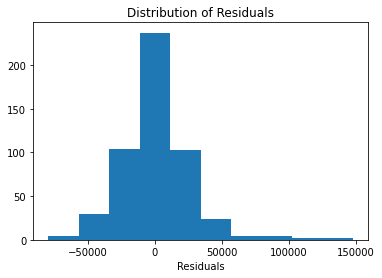

In [80]:
plt.hist(residuals)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals');

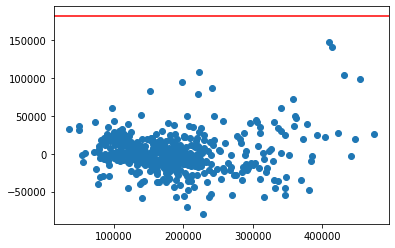

In [87]:
plt.axhline(y.mean(), color = 'r')
plt.scatter(lasso_cv.predict(X_test), residuals);

---
## Conclusion

There is a very slight increase in the $R^2$ score for this model i.e<b> 80% </b>

The fact that the Lasso regression technique had little effect on the model compared to the linear regression model indicates that our model doesn't have a high variance. 

In the next notebook, I will use another regression technique called Ridge regresssion

## Kaggle Submission

In [82]:
y_kaggle = lasso_cv.predict(df_test_ss) 

Create a dataframe of the ID and predicted sale price

In [83]:
df_test['SalePrice'] = y_kaggle
model_submission = df_test[['Id','SalePrice' ]]
model_submission

,Id,SalePrice
0,2658,73046.892930
1,2718,143836.315664
2,2414,220929.725314
3,1989,106021.270806
4,625,179192.477129
...,...,...
873,1662,188835.421132
874,1234,210405.862688
875,1373,126783.665859
876,1672,104319.940141


## Export

#### Export model_submission dataframe

In [84]:
model_submission.set_index('Id', inplace=True)

In [85]:
model_submission.to_csv('../datasets/lasso_model.csv')